In [1]:
import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import pickle
import sys

# From arm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm

from MouseArmTransformer import (
    criterion,
    data,
    helper,
    inference,
    model,
    training,
)
from mausspaun.visualization.plot_3D_video import plot_3d_video, plot_split_3d_video
from mausspaun.datajoint import analysis

%load_ext autoreload
%autoreload 2

In [4]:
scan_key_list = [{'mouse_name': 'HoneyBee', 'day': 77, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 81, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 82, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 84, 'attempt': 2, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 86, 'attempt': 1, 'scan_idx': 0},
        {'mouse_name': 'Jaguar', 'day': 19, 'attempt': 2, 'scan_idx': 0},
        {'mouse_name': 'HoneyBee', 'day': 83, 'attempt': 1, 'scan_idx': 0}] # Force field

In [5]:
# Define base path for all sessions
base_data_path = '/data/mausspaun/without_muscles/session_data_Apr17/'

all_errors = []
for scan_key in scan_key_list:
    print(scan_key)
    mouse_path = f"mouse-{scan_key['mouse_name']}_day-{scan_key['day']}_attempt-{scan_key['attempt']}"
    mouse_data = np.load(base_data_path + mouse_path + '.npy', allow_pickle=True)[()]
    
    transformer_3D = mouse_data['mujoco_dlc_3d']
    
    avg_error, errors = inference.evaluate_ground_truth(transformer_3D, scan_key['mouse_name'], scan_key['day'], scan_key['attempt'], verbose=0)
    
    scan_key_str = f"{scan_key['mouse_name']}_day-{scan_key['day']}_attempt-{scan_key['attempt']}"
    errors['scan_key'] = scan_key_str
    
    all_errors.append(errors)
    
aggregated_errors = pd.concat(all_errors, ignore_index=True)

{'mouse_name': 'HoneyBee', 'day': 77, 'attempt': 1, 'scan_idx': 0}
--- Found labels at /data/mausspaun/labeled/rigVideo_mouse-HoneyBee_day-77_attempt-1_part-0_2024-01-18_09-15_points3d_diff.csv
Connecting to robot config...
MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028
{'mouse_name': 'HoneyBee', 'day': 81, 'attempt': 1, 'scan_idx': 0}
--- Found labels at /data/mausspaun/labeled/rigVideo_mouse-HoneyBee_day-81_attempt-1_part-0_2024-01-23_10-55_points3d_diff.csv
Connecting to robot config...
MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028
{'mouse_name': 'HoneyBee', 'day': 82, 'attempt': 1, 'scan_idx': 0}
--- Found labels at /data/mausspaun/labeled/rigVideo_mouse-HoneyBee_day-82_attempt-1_part-0_2024-01-23_10-43_points3d_diff.csv
Connecting to robot config...
MuJoCo session created
MuJoCO session closed...
Procrustes alignment error: 0.008391397293761028
{'mouse_name': 'HoneyBee', 'day': 84,

In [8]:
aggregated_errors

,frame,marker,error,scan_key
0,5.0,right_shoulder,0.386656,HoneyBee_day-77_attempt-1
1,5.0,right_elbow,0.256153,HoneyBee_day-77_attempt-1
2,5.0,right_wrist,0.468463,HoneyBee_day-77_attempt-1
3,5.0,right_wrist_top,0.533636,HoneyBee_day-77_attempt-1
4,5.0,right_wrist_bottom,0.632501,HoneyBee_day-77_attempt-1
...,...,...,...,...
2965,372.0,left_finger0,0.300456,HoneyBee_day-86_attempt-1
2966,372.0,left_finger1,0.173584,HoneyBee_day-86_attempt-1
2967,372.0,left_finger2,0.156630,HoneyBee_day-86_attempt-1
2968,372.0,left_finger3,0.348509,HoneyBee_day-86_attempt-1


In [9]:
aggregated_errors['marker'].unique()

array(['HoneyBee_day-77_attempt-1', 'HoneyBee_day-81_attempt-1',
       'HoneyBee_day-82_attempt-1', 'HoneyBee_day-86_attempt-1'],
      dtype=object)

In [35]:
plt.style.use('cyhsm')

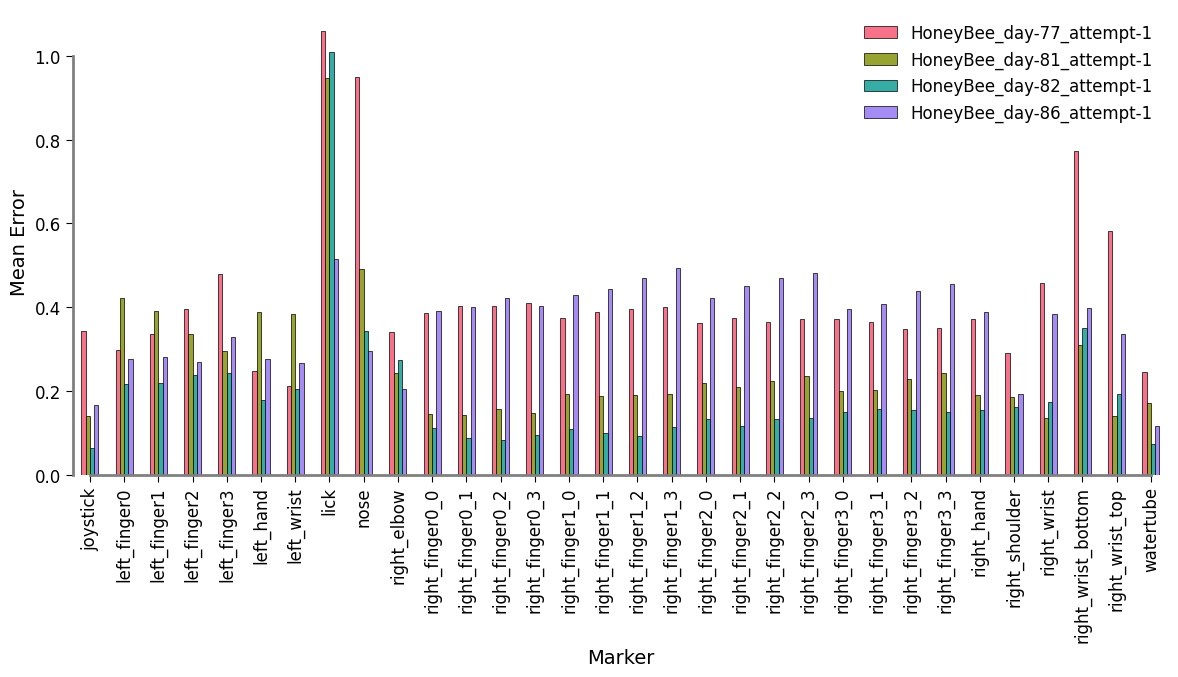

In [40]:
filtered_errors = aggregated_errors[aggregated_errors['marker'] != 'left_elbow']

# Calculate the mean error for each marker across each session
mean_errors = filtered_errors.groupby(['scan_key', 'marker'])['error'].mean().unstack()

# Set a nicer color scheme
#sns.set_theme(style="whitegrid")
colors = sns.color_palette("husl", len(mean_errors.index))

# Plotting the results
mean_errors.T.plot(kind='bar', figsize=(12, 7), color=colors, linewidth=0.5)

# Customizing the plot
plt.xlabel('Marker')
plt.ylabel('Mean Error')
#plt.legend(title='Session', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.xticks(rotation=90)
plt.grid(False)
plt.tight_layout()

sns.despine(trim=True)
plt.savefig('./transformer_error.svg', transparent=True)
plt.show()